# Filter allele-specific sci-ATAC-seq counts for all F1s and all timepoints

In [1]:
experiment_ids = 'f1'
timepoints = 'all'
regions = 'cusanovich_dm6_peaks_1kb'
correction = 'wasp'

In [2]:
label = '_'.join([experiment_ids, timepoints, 'windows'])
wasp_corrected = True if correction == 'wasp' else False

## Imports

In [3]:
# general
import sys
import os
from functools import partial

In [4]:
# tools
import numpy as np
import pandas as pd
import scanpy as sc
import patac as pa

sc.settings.verbosity = 3

In [5]:
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [6]:
# local
sys.path.append('..')
from utils import settings
from utils import dataloader

### Load processed total counts and allelic counts

In [7]:
adata_total = sc.read(os.path.join(settings.DATA_DIR, label, 'total_counts_vae_processed.h5ad'))

In [8]:
# extract actual timepoints and experiment ids
timepoints = adata_total.obs['timepoint'].unique().tolist()
exp_ids = adata_total.obs['exp_id'].unique().tolist()

In [9]:
# load allele-specific counts
adatas_allelic = dict()
for exp_id in exp_ids:
    adata = dataloader.load_allelic(
        exp_ids=exp_id,
        timepoints=timepoints,
        wasp_corrected=wasp_corrected,
        regions=regions)
    
    # filter for cells present in adata_total
    cell_names = adata_total.obs.query('exp_id == @exp_id').index
    adata = adata[cell_names, :]

    # copy cell states and annotations
    adata.obsm = adata_total[cell_names, :].obsm
    adata.obs['time_vae'] = adata_total[cell_names, :].obs['time_vae']
    adata.obs['leiden_vae'] = adata_total[cell_names, :].obs['leiden_vae']
    adata.obs['lineage_muscle'] = adata_total[cell_names, :].obs['lineage_muscle']
    adata.obs['lineage_nervous'] = adata_total[cell_names, :].obs['lineage_nervous']
    adata.obs['annotation'] = adata_total[cell_names, :].obs['annotation']
    for key in adata_total.uns.keys():
        if 'color' in key:
            adata.uns[key] = adata_total.uns[key]
    adatas_allelic[exp_id] = adata

Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/f1_analysis/data/.cache/SS148.cusanovich_dm6_peaks_1kb.wasp.counts_allele1.h5ad ... found.
 -> loading cached anndata ...
Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/f1_analysis/data/.cache/SS148.cusanovich_dm6_peaks_1kb.wasp.counts_allele2.h5ad ... found.
 -> loading cached anndata ...


/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/f1_analysis/data/.cache/SS157.cusanovich_dm6_peaks_1kb.wasp.counts_allele1.h5ad ... found.
 -> loading cached anndata ...
Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/f1_analysis/data/.cache/SS157.cusanovich_dm6_peaks_1kb.wasp.counts_allele2.h5ad ... found.
 -> loading cached anndata ...
Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/f1_analysis/data/.cache/SS158.cusanovich_dm6_peaks_1kb.wasp.counts_allele1.h5ad ... found.
 -> loading cached anndata ...
Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/f1_analysis/data/.cache/SS158.cusanovich_dm6_peaks_1kb.wasp.counts_allele2.h5ad ... found.
 -> loading cached anndata ...
Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/f1_analysis/data/.cache/SS159.cusanovich_dm6_peaks_1kb.wasp.counts_allele1.h5ad ... found.
 -> loading cached anndata ...
Check

## Filter

In [10]:
for exp_id, adata in adatas_allelic.items():
    adata = pa.pp.apply_to_layer(
        adata,
        layer='allelic_total',
        func=partial(sc.pp.filter_genes, min_cells=50))
    n_peaks = adata.shape[1]
    pa.pp.filter_chromosomes(adata, chrs=['chrX', 'chrY'])
    print('filtered out %d peaks on sex chromosomes, %d remaining' % (n_peaks - adata.shape[1], adata.shape[1]))
    adata = pa.pp.apply_to_layer(
        adata,
        layer='allelic_total',
        func=pa.pp.calculate_qc_metrics)

    adata.var['allelic_counts'] = adata.X.sum(0).A1
    adata.var['mean_accessible'] = adata.var['total_counts'] / adata.var['n_cells_by_counts']
    adatas_allelic[exp_id] = adata

filtered out 10514 genes that are detected in less than 50 cells
filtered out 6023 peaks on sex chromosomes, 36596 remaining
filtered out 12762 genes that are detected in less than 50 cells
filtered out 5453 peaks on sex chromosomes, 34918 remaining
filtered out 11894 genes that are detected in less than 50 cells
filtered out 5636 peaks on sex chromosomes, 35603 remaining
filtered out 13104 genes that are detected in less than 50 cells
filtered out 5323 peaks on sex chromosomes, 34706 remaining


### Plot QC metrics before filtering

In [11]:
keys = ['n_cells_by_counts', 'total_counts', 'mean_counts', 'mean_accessible']

df = pd.DataFrame()
for exp_id, adata in adatas_allelic.items():
    df_exp_id = adata.var[keys].melt()
    df_exp_id['exp_id'] = exp_id
    df = df.append(df_exp_id)

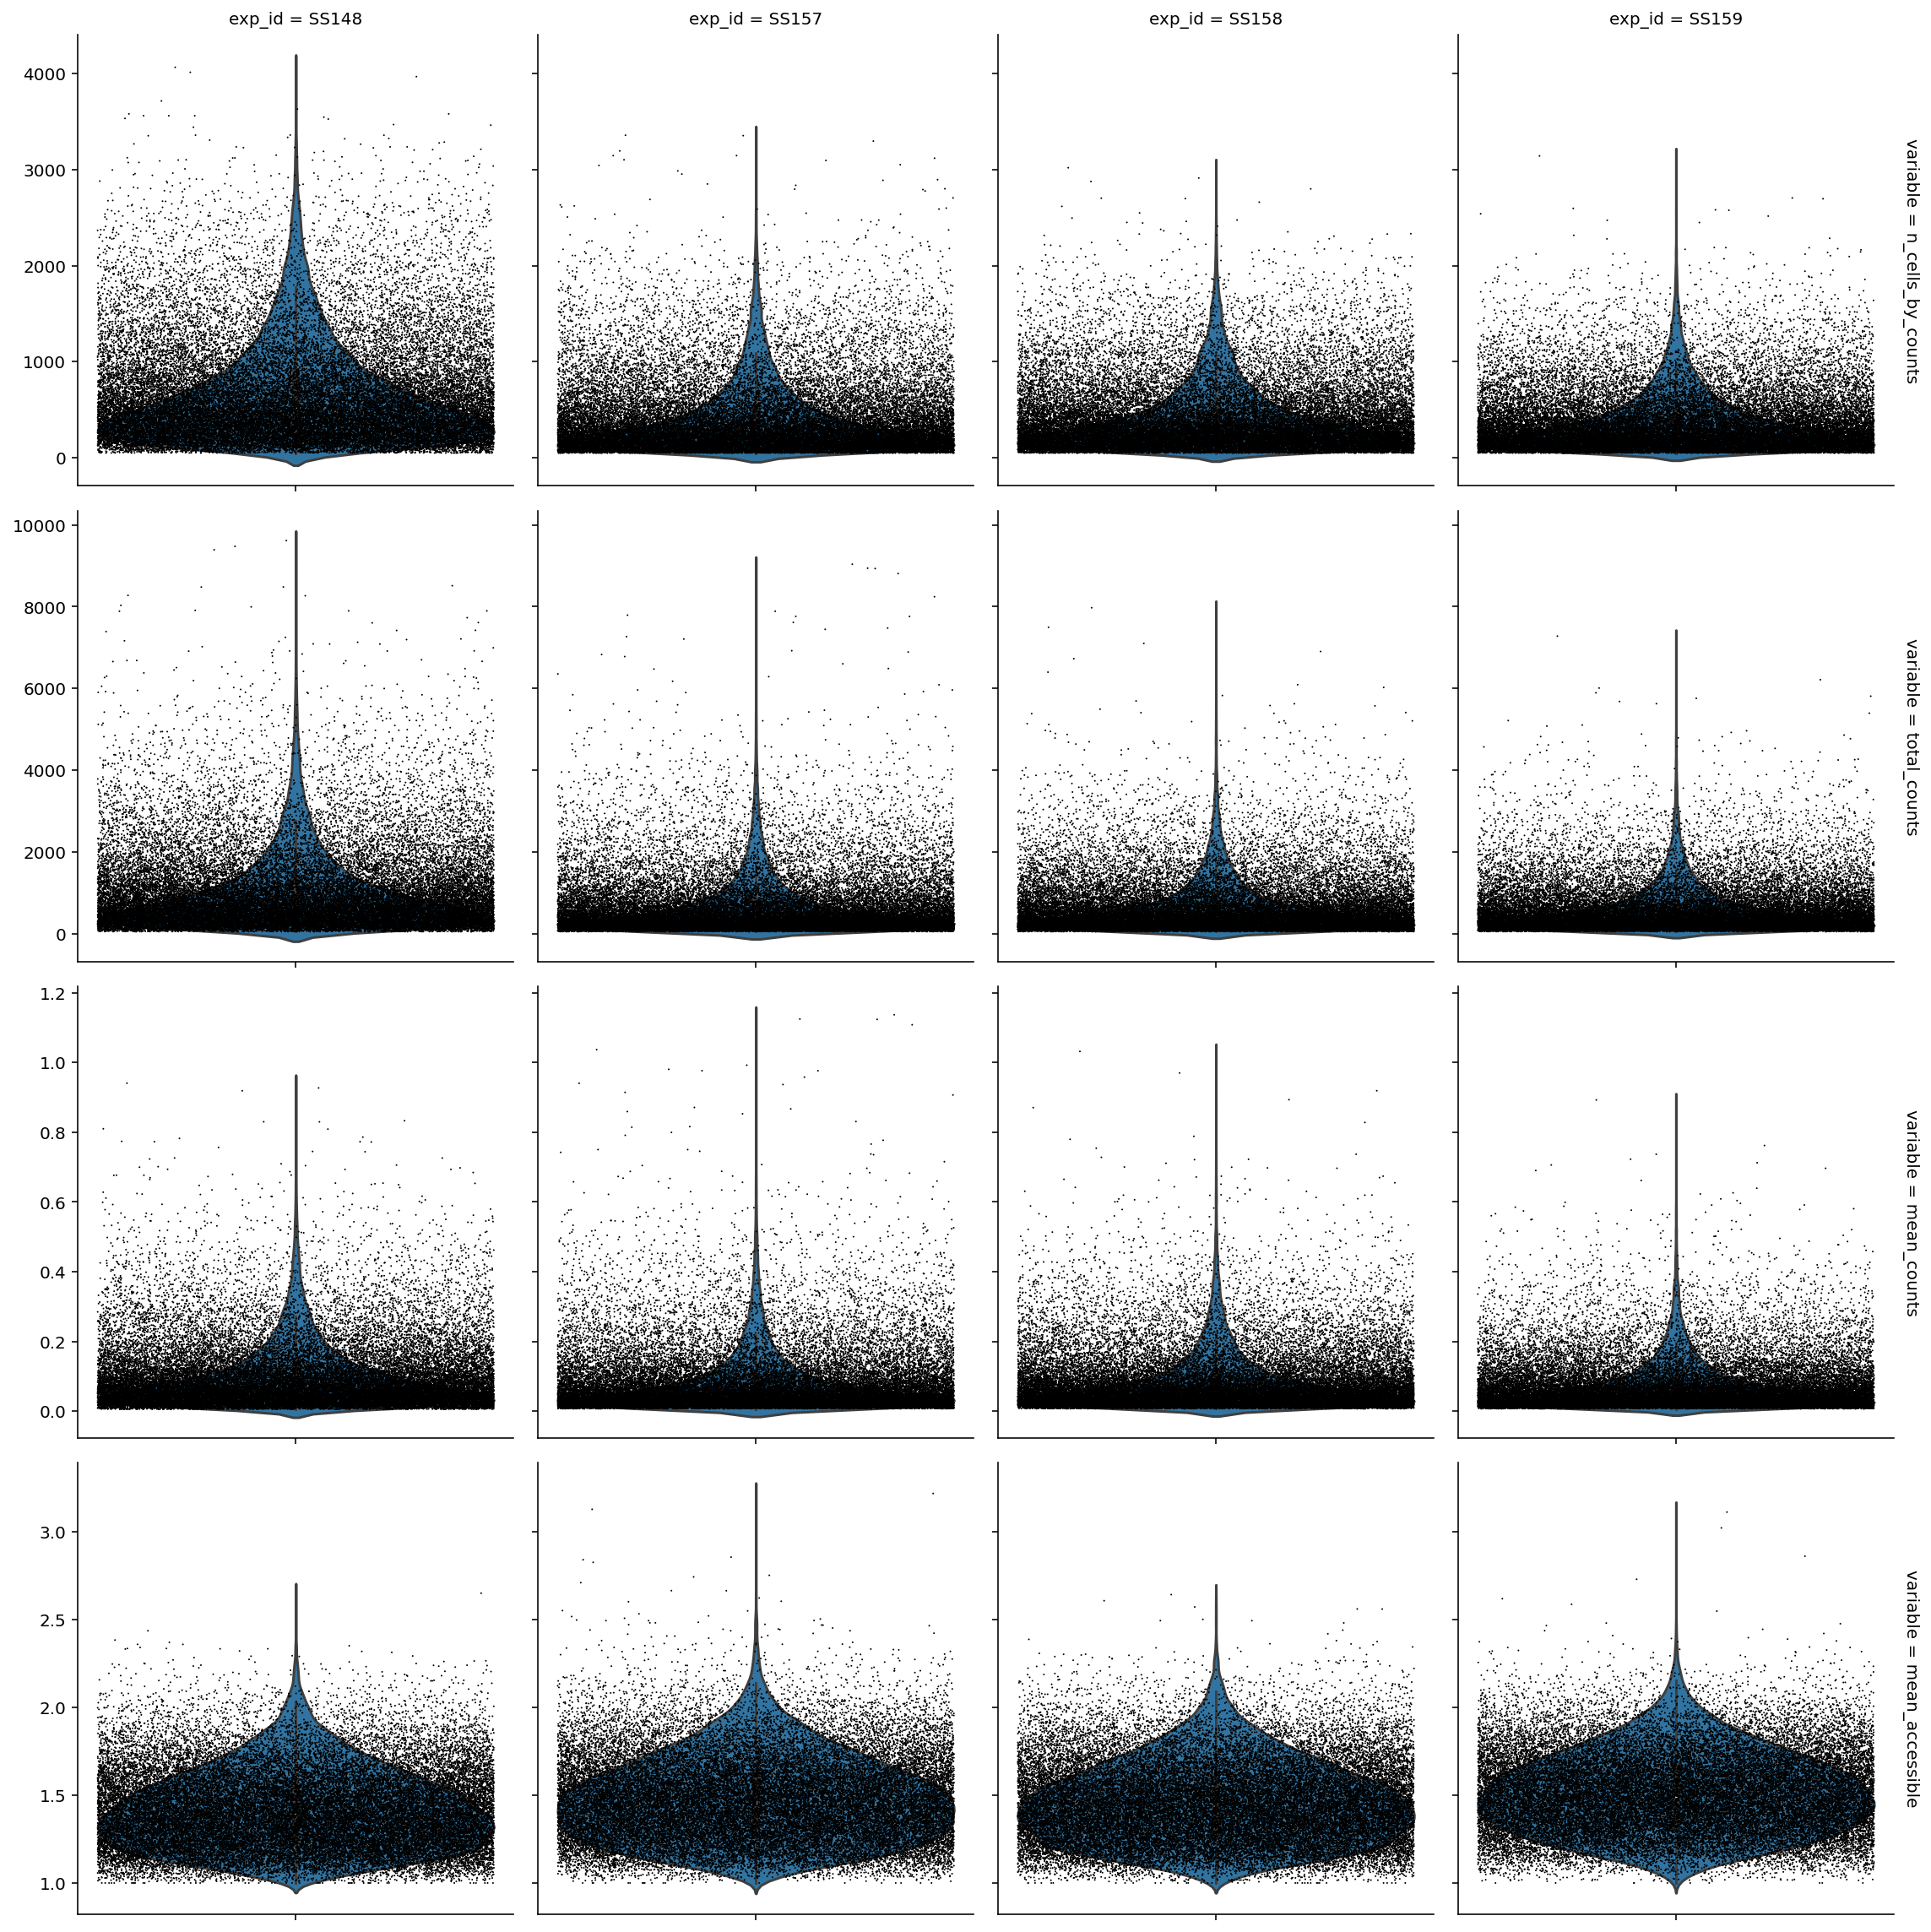

In [12]:
g = sns.catplot(
    data=df, 
    y='value', 
    kind='violin', 
    row='variable', 
    row_order=keys, 
    col='exp_id',
    height=4, 
    sharey='row',
    margin_titles=True)
g.map_dataframe(sns.stripplot, y="value", jitter=.4, size=1, color='black');

Filter by mean counts. Low peak mean either means few cells or low counts per cell. Both cases make estimation of cell-state variation difficult.

In [13]:
for exp_id in exp_ids:
    print('[f1_analysis] Filtering %s ' % exp_id)
    adata = adatas_allelic[exp_id]
    print('   peaks before filtering: ' + str(adata.shape[1]))
    adata = adata[:, adata.var['mean_counts'] > 0.1]
    print('   peaks after filtering:  ' + str(adata.shape[1]))
    adatas_allelic[exp_id] = adata

[f1_analysis] Filtering SS148 
   peaks before filtering: 36596
   peaks after filtering:  12861
[f1_analysis] Filtering SS157 
   peaks before filtering: 34918
   peaks after filtering:  9045
[f1_analysis] Filtering SS158 
   peaks before filtering: 35603
   peaks after filtering:  9584
[f1_analysis] Filtering SS159 
   peaks before filtering: 34706
   peaks after filtering:  8040


/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be 

### Plot QC metrics after filtering

In [14]:
keys = ['n_cells_by_counts', 'total_counts', 'mean_counts', 'mean_accessible']

df = pd.DataFrame()
for exp_id, adata in adatas_allelic.items():
    df_exp_id = adata.var[keys].melt()
    df_exp_id['exp_id'] = exp_id
    df = df.append(df_exp_id)

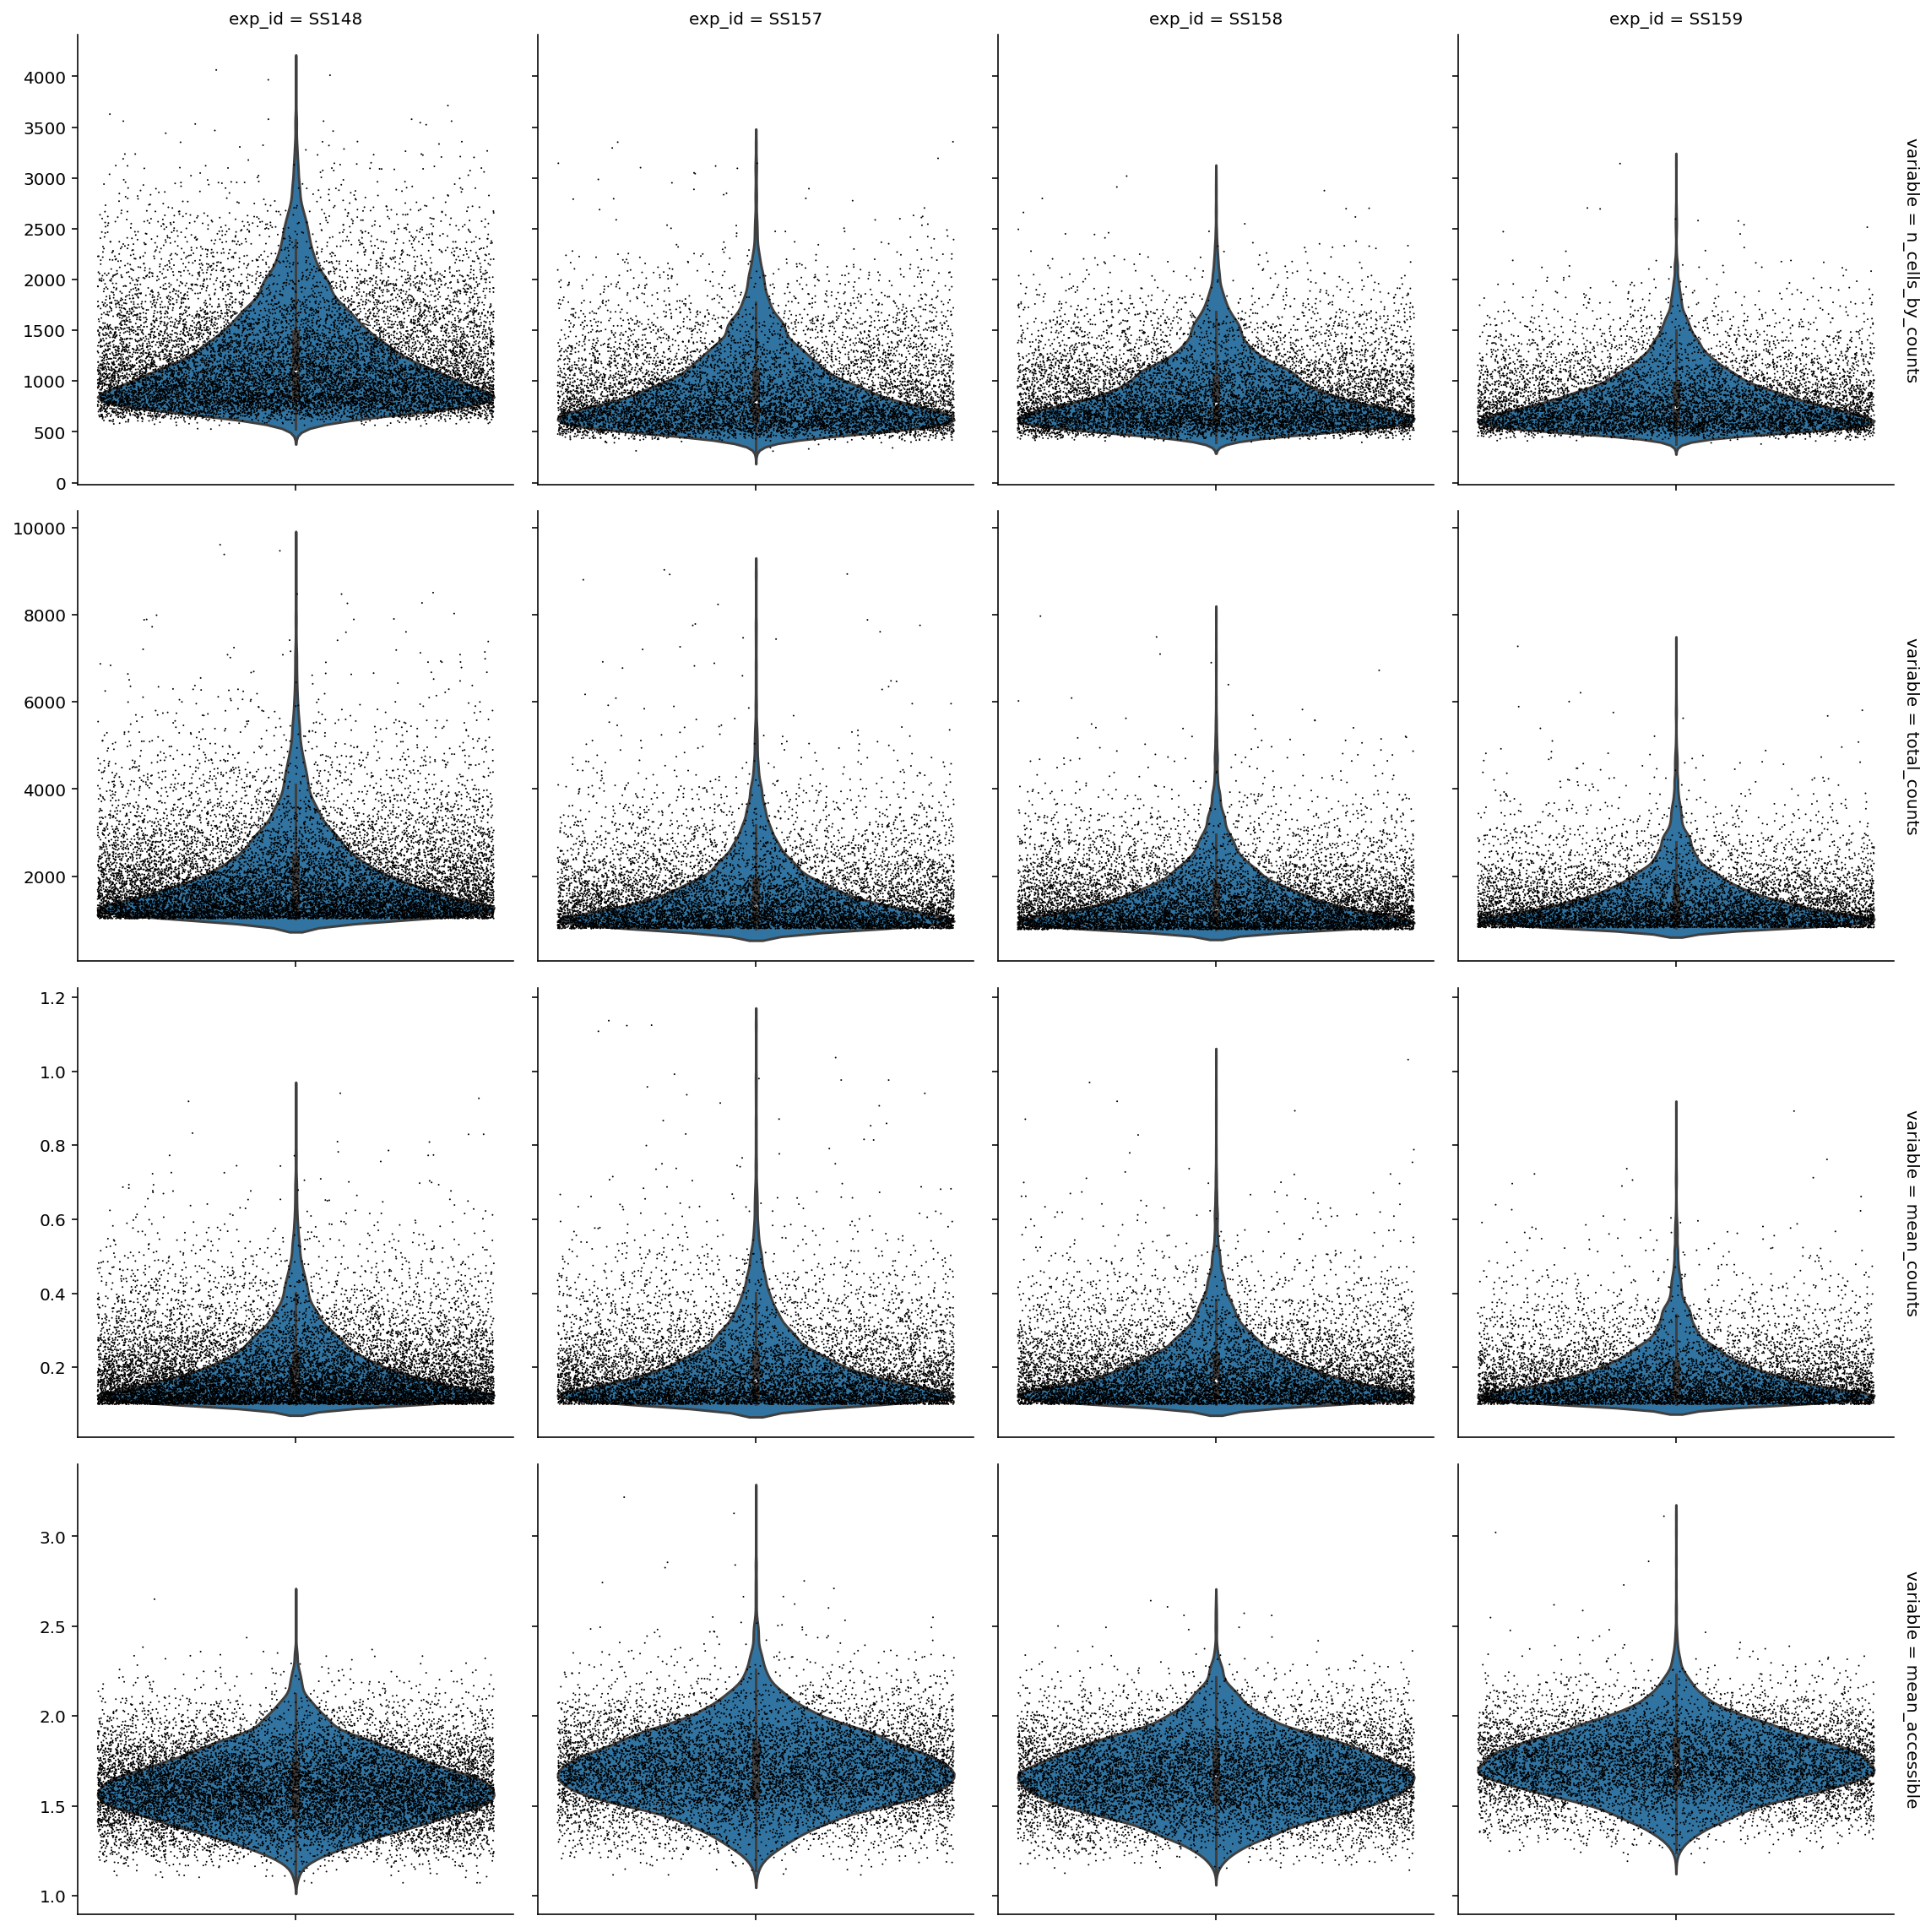

In [15]:
g = sns.catplot(
    data=df, 
    y='value', 
    kind='violin', 
    row='variable', 
    row_order=keys, 
    col='exp_id',
    height=4, 
    sharey='row',
    margin_titles=True)
g.map_dataframe(sns.stripplot, y="value", jitter=.4, size=1, color='black');

### Add filter for each lineage

In [16]:
for exp_id in exp_ids:
    adata = adatas_allelic[exp_id]
    for lineage in ['muscle', 'nervous']:
        lineage_ids = adata.obs['lineage_%s' % lineage].to_numpy()
        lineage_filter = adata[lineage_ids, :].layers['allelic_total'].mean(0).A.ravel() > .1
        
        print('[f1_analysis] %s' % exp_id)
        print('peaks in lineage %s: %d' % (lineage, lineage_filter.sum()))
        adata.var['lineage_%s_covered' % lineage] = lineage_filter
    adatas_allelic[exp_id] = adata

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.var` of view, copying.


[f1_analysis] SS148
peaks in lineage muscle: 11074


Trying to set attribute `.var` of view, copying.


[f1_analysis] SS148
peaks in lineage nervous: 8466
[f1_analysis] SS157
peaks in lineage muscle: 8155


Trying to set attribute `.var` of view, copying.


[f1_analysis] SS157
peaks in lineage nervous: 5973
[f1_analysis] SS158
peaks in lineage muscle: 8912


Trying to set attribute `.var` of view, copying.


[f1_analysis] SS158
peaks in lineage nervous: 6320
[f1_analysis] SS159
peaks in lineage muscle: 7118
[f1_analysis] SS159
peaks in lineage nervous: 4966


## Save

In [17]:
for exp_id in exp_ids:
    adata = adatas_allelic[exp_id]

    fname = '_'.join([exp_id, regions, correction, 'allelic_counts.h5ad'])
    adata.write(os.path.join(settings.DATA_DIR, label, fname))